<a href="https://colab.research.google.com/github/ErikFantomex/Chatterbot-TIAI/blob/main/Chatbot_TAIA_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Proyecto Final Topicos Avanzados IA
Horacio Araiza Gonzalez

Creacion de un chatbot reportero de noticias


# Preprocesamiento

In [ ]:
!pip install chatterbot
!pip install chatterbot-corpus

In [4]:
import pandas as pd
import nltk
nltk.download('punkt')
import re
import requests
from bs4 import BeautifulSoup
from chatterbot import ChatBot
from chatterbot.trainers import ListTrainer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:

#iniciamos
url = 'https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html'
page = requests.get(url)
page = page.text
soup = BeautifulSoup(page, features="lxml")
for script in soup(["script", "style"]):
    script.decompose()
raw_text  = soup.get_text()

cleaned = re.sub(r"(?is)<(script|style).*?>.*?(\1>)", "", raw_text.strip())
cleaned = re.sub(r"(?s)[\n]?", "", cleaned)
cleaned = re.sub(r"(?s)<.*?>", " ", cleaned)
cleaned = re.sub(r" ", " ", cleaned)
cleaned = re.sub(r"  ", " ", cleaned)
cleaned = re.sub("\n", " ", cleaned)
cleaned = cleaned.strip()

tokens = nltk.sent_tokenize(cleaned)
for token in tokens:
  print('-> ', token, '\n')
     


In [ ]:
url = 'https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html'
page = requests.get(url)
page = page.text
soup = BeautifulSoup(page, features="lxml")
for script in soup(["script", "style"]):
    script.decompose()
raw_text  = soup.get_text()

cleaned = re.sub(r"(?is)<(script|style).*?>.*?(\1>)", "", raw_text.strip())
cleaned = re.sub(r"(?s)[\n]?", "", cleaned)
cleaned = re.sub(r"(?s)<.*?>", " ", cleaned)
cleaned = re.sub(r" ", " ", cleaned)
cleaned = re.sub(r"  ", " ", cleaned)
cleaned = re.sub("\n", " ", cleaned)
cleaned = re.sub("'", " ", cleaned)
cleaned = re.sub("\"", " ", cleaned)
cleaned = cleaned.strip()
     


# Vectorizacion

In [ ]:
sent_tokens = nltk.sent_tokenize(cleaned)
word_tokens = nltk.word_tokenize(cleaned)

In [ ]:
import math

total_ocurrences = {}
occured_in_n_docs = {}

for sentence in sent_tokens:
  for word in word_tokens:
 
    c = sentence.count(word)
 
    try:
      total_ocurrences[word] += c
    except KeyError:
      total_ocurrences[word] = c 
 
    if c > 0:
      try:
        occured_in_n_docs[word] += 1
      except KeyError:
        occured_in_n_docs[word] = 1
 

tfidf = []
i = 0
for sentence in sent_tokens:
  w = {"sentence_n": i}
  for word in word_tokens:
    # w = tf * log(N/df)
    tf = sentence.count(word)
    N = total_ocurrences[word]
    df = occured_in_n_docs[word]
    if tf == 0:
      w[word] = 0
    else:
      w[word] = tf * math.log(N/df)
  tfidf.append(w)
  i += 1


In [ ]:
pd.DataFrame(tfidf)
     

# Similaridad de coseno

In [ ]:
url = 'https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html'
page = requests.get(url)
page = page.text
soup = BeautifulSoup(page, features="lxml")
for script in soup(["script", "style"]):
    script.decompose()
raw_text  = soup.get_text()

cleaned = re.sub(r"(?is)<(script|style).*?>.*?(\1>)", "", raw_text.strip())
cleaned = re.sub(r"(?s)[\n]?", "", cleaned)
cleaned = re.sub(r"(?s)<.*?>", " ", cleaned)
cleaned = re.sub(r" ", " ", cleaned)
cleaned = re.sub(r"  ", " ", cleaned)
cleaned = re.sub("\n", " ", cleaned)
cleaned = re.sub("'", " ", cleaned)
cleaned = re.sub("\"", " ", cleaned)
cleaned = cleaned.strip()

sent_tokens = nltk.sent_tokenize(cleaned)

In [ ]:

similaridades = []
for sentece in sent_tokens:
  row = []
  A = {w for w in nltk.word_tokenize(sentece)}
  for another_sentence in sent_tokens:
    l1 =[]
    l2 =[]
    B = {w for w in nltk.word_tokenize(another_sentence)}
    v = A.union(B) 
    for w in v:
      l1.append(1 if w in A else 0)
      l2.append(1 if w in B else 0)
    c = 0
    for i in range(len(v)):
        c+= l1[i]*l2[i]
    row.append(c / float((sum(l1) * sum(l2)) ** 0.5))
  similaridades.append(row)

In [ ]:
pd.DataFrame(similaridades)

# Chatbot

In [9]:
#alimentando el chatbot con noticias
url_list = [
            "https://es.wikipedia.org/wiki/Ucrania",
            "https://es.wikipedia.org/wiki/Rusia",
            "https://es.wikipedia.org/wiki/Invasi%C3%B3n_rusa_de_Ucrania_de_2022",
            "https://es.wikipedia.org/wiki/Guerra_del_Domb%C3%A1s",
            "https://es.wikipedia.org/wiki/Crimea",
            "https://cnnespanol.cnn.com/2022/12/08/ultima-hora-noticias-guerra-rusia-ucrania-orix-58/",
            "https://cnnespanol.cnn.com/2022/11/09/jerson-rusia-guerra-ucrania-orix/",
            "https://cnnespanol.cnn.com/2022/12/05/ultima-hora-noticias-guerra-rusia-ucrania-orix-55/",
            "https://cnnespanol.cnn.com/",
            "https://www.nytimes.com/es/",
            "https://github.com/CodeandoMexico/comunidad",
            "https://elpais.com/mexico/2022-12-08/lopez-obrador-confirma-que-pedro-castillo-solicito-asilo-en-mexico.html",
            "https://www.milenio.com/",
            "https://www.bbc.com/mundo/noticias-america-latina-63898035",
            "https://www.bbc.com/mundo/noticias-america-latina-63910513",
            "https://www.bbc.com/mundo/noticias-internacional-63893656",
            "https://medium.com/codeandomexico",
            "https://github.com/CodeandoMexico/comunidad/blob/master/GLOSARIO.md",
            "https://www.milenio.com/internacional/peru-la-presidenta-dina-boluarte-tambien-podria-ser-destituida",
            "https://www.bbc.com/mundo/noticias-america-latina-63895102",
            "https://es.wikipedia.org/wiki/Periodismo",
            "https://es.wikipedia.org/wiki/Periodista",
            "https://es.wikipedia.org/wiki/Historia_del_periodismo",
            "https://es.wikipedia.org/wiki/Periodismo_en_M%C3%A9xico",
            "https://es.wikipedia.org/wiki/Televisi%C3%B3n"
            ]


all_senteces = []
for url in url_list:
  page = requests.get(url)
  page = page.text
  soup = BeautifulSoup(page, features="lxml")
  for script in soup(["script", "style"]):
      script.decompose()
  raw_text  = soup.get_text()

  cleaned = re.sub(r"(?is)<(script|style).*?>.*?(\1>)", "", raw_text.strip())
  cleaned = re.sub(r"(?s)[\n]?", "", cleaned)
  cleaned = re.sub(r"(?s)<.*?>", " ", cleaned)
  cleaned = re.sub(r" ", " ", cleaned)
  cleaned = re.sub(r"  ", " ", cleaned)
  cleaned = re.sub("\n", " ", cleaned)
  cleaned = re.sub("'", " ", cleaned)
  cleaned = re.sub("\"", " ", cleaned)
  cleaned = cleaned.strip()
  sent_tokens = nltk.sent_tokenize(cleaned)
  for token in sent_tokens:
    all_senteces.append(token)

In [10]:
bot = ChatBot(
    'BotReportero',
    storage_adapter='chatterbot.storage.SQLStorageAdapter',
    database_uri='sqlite:///database.sqlite3'
    )
    
chat = ListTrainer(bot)
chat.train(all_senteces)

List Trainer: [                    ] 0%

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


List Trainer: [####################] 100%


In [11]:
while True:
  response = bot.get_response(input("Pregunta: "))
  print("[Confianza en la respuesta: {:}%]\nRespuesta:".format(100*float(response.confidence)), response)

Pregunta: Hola
[Confianza en la respuesta: 0.0%]
Respuesta: The Hindu.
Pregunta: Cual
[Confianza en la respuesta: 5.0%]
Respuesta: [347]​ La televisión es el medio más popular en Rusia.
Pregunta: Russia
[Confianza en la respuesta: 0.0%]
Respuesta: Consultado el 28 de febrero de 2022.
Pregunta: Television mexico
[Confianza en la respuesta: 0.0%]
Respuesta: ABC.
Pregunta: ¿Russia y crimea?
[Confianza en la respuesta: 17.0%]
Respuesta: Bbc.com.
Pregunta: Russia historia
[Confianza en la respuesta: 16.0%]
Respuesta: [80] O jornalista britânico Edward Lucas descreveu-o como revisionismo histórico .
Pregunta: Mexico
[Confianza en la respuesta: 0.0%]
Respuesta: [4]​ Según datos del Comité para la Protección de los Periodistas han sido asesinados 134 periodistas entre 1992 y 2021, con una media de uno cada seis semanas.
Pregunta: D90
[Confianza en la respuesta: 0.0%]
Respuesta: Consultado el 25 de febrero de 2022.
Pregunta: Mexico periodismo
[Confianza en la respuesta: 2.0%]
Respuesta: [24]​Pe

KeyboardInterrupt: ignored

# Resultados 

Pruebas con chatbot reportero 


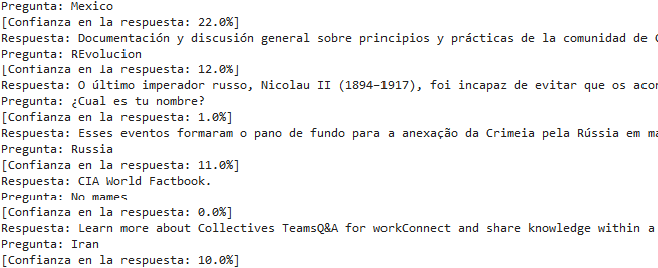

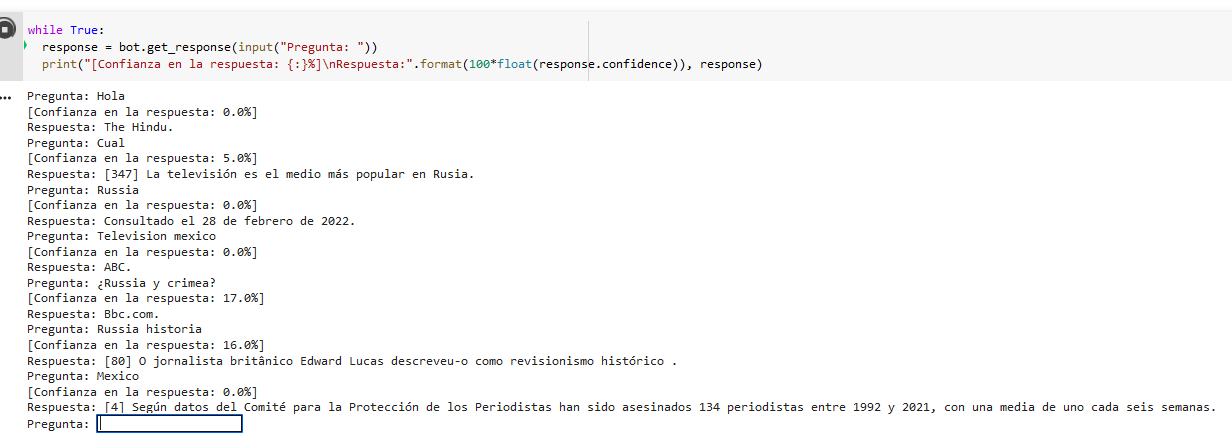

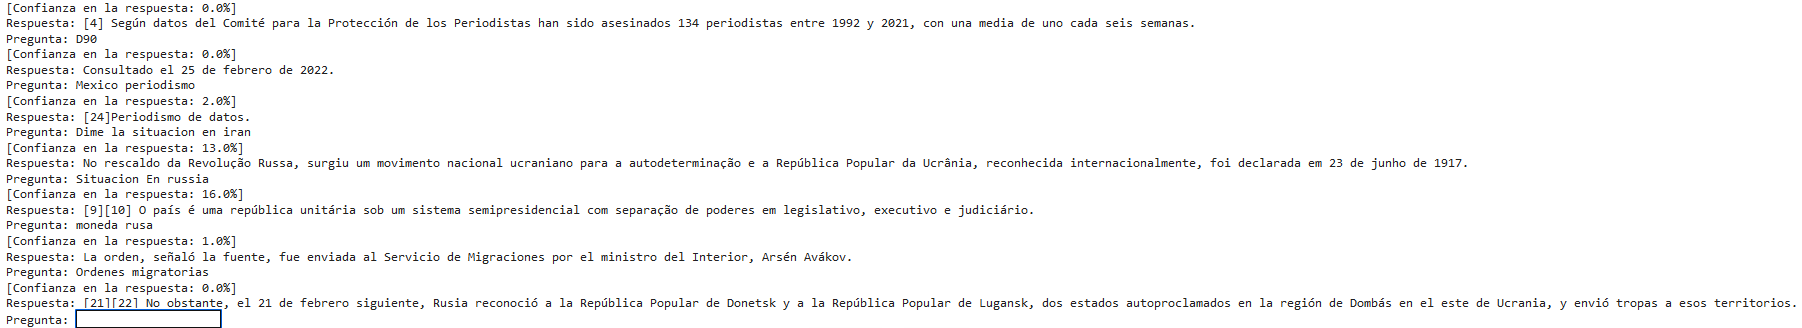

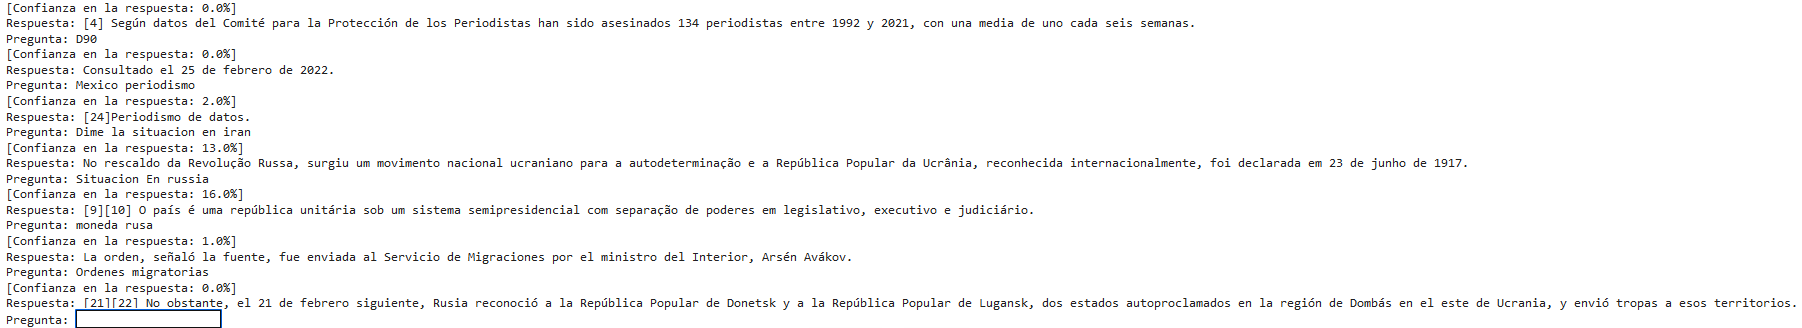